# Импорты

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import control 
import sympy
import os
import scipy

In [2]:
sympy.init_printing()
p = sympy.Symbol("p")
s = sympy.Symbol("s")
t = sympy.Symbol("t")
w = sympy.Symbol("w")
I = sympy.I

In [3]:
def get_t(end_t = 10, dt=0.001, start_t = 0):
    return np.linspace(start_t, end_t, int(end_t / dt))

# Задание 1

In [4]:
def get_controllability_gramian(A, B, end_time):
    f = lambda time: scipy.linalg.expm(A * time) @ B @ B.T @ scipy.linalg.expm(A.T * time)
    return scipy.integrate.quad_vec(f, 0, end_time)

In [9]:
def get_u_for_controllable(A, B, x1, end_time):
    u = []
    times = get_t(end_time)
    control_gramian_matrix, _ = get_controllability_gramian(A, B, end_time)
    for t in times:
        u.append(B.T @ scipy.linalg.expm(A.T * (end_time - t)) @ np.linalg.pinv(control_gramian_matrix) @ x1)
    return np.array(u).reshape((B.shape[1], -1)), times

In [44]:
def plot_task1(A, B, x1, end_time, file_name='test.jpg'):
    u, times = get_u_for_controllable(A, B, x1, end_time)
    ss = control.ss(A, B, A * 0, B * 0)
    output = control.forced_response(ss, X0=[0,0,0], U=u, T=times).states

    fig, axs = plt.subplots(2, 1, figsize=(8, 8))
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
    for i in range(3):
        axs[0].plot(times, output[i], linewidth=4, label=f"$x_{i}$")
        # axs[i//2, i % 2].set_title(f'x_{i} = x_{i}(t)', fontsize=12)
        axs[0].set_xlabel(f"t, [c]", fontsize=12)
        axs[0].grid(True)
        
    axs[0].set_title(f"Графики компонент")
    axs[0].scatter([end_time, end_time, end_time], [x1[0], x1[1], x1[2]], color='r', linewidth=4, label='Цель')
    axs[0].legend()
    
    axs[1].set_title(f"График сигнала управления управления")
    axs[1].plot(times, u.reshape(-1), linewidth=4, label="Управление")
    axs[1].set_xlabel(f"t, [c]", fontsize=12)
    axs[1].grid(True)
    axs[1].legend()
    plt.show()

In [45]:
task1_A = np.array([
    [3, 4, -1],
    [-10, -11, -4],
    [10, 10, 3]
])
task1_B = np.array([[-2], [5], [-3]])
task1_x1 = np.array([[-2], [1], [-1]])
task1_end_time = 3

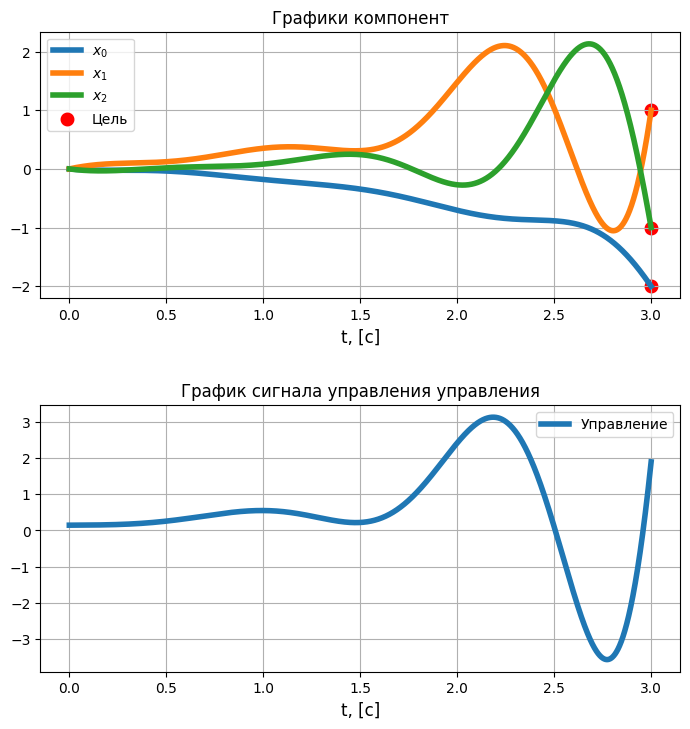

In [46]:
plot_task1(task1_A, task1_B, task1_x1, task1_end_time, 'task1')

# Задание 2

# Задание 3

# Задание 4